# Patches

## Importing Libraries

In [26]:
# Standard library imports
import itertools
import random

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import lightning.pytorch as pl
from torchsummary import summary
from torchmetrics import Accuracy

## Hyperparameters

In [57]:
learning_rate = 1e-03
weight_decay = 1e-04
batch_size = 128
epochs = 50
img_size = (36,36)
train_size = 0.8
num_classes = 8
all_indices = set(range(9))
permutations = {i: list(all_indices - {i}) for i in all_indices}

## Dataloader (2 Patches)

In [35]:
class Cifar10Dataset(Dataset):
    def __init__(self, images, transforms=None):
        self.images = images
        self.transforms = transforms
        self.patch_size = 12
        
        # Simplified permutations dictionary
        self.permutations = {i: [j for j in range(9) if j != i] for i in range(9)}

    def __len__(self):
        return len(self.images)
    
    

    def extract_patch(self, img, idx):
        """Extract a patch from the image given an index."""
        row, col = idx // 3, idx % 3
        row_start, row_end = row * self.patch_size , (row+1) * self.patch_size
        col_start, col_end = col * self.patch_size, (col +1)* self.patch_size 
        return img[:, row_start:row_end, col_start:col_end]

    def __getitem__(self, idx):
        img = self.images[idx]
        
        if self.transforms:
            img = self.transforms(img)
        
        orig_img = img.clone()  # Ensure we're not modifying the original
        
        # Get two random patch indices
        patch_1_idx = np.random.randint(9)
        relative_position = np.random.randint(8)
        patch_2_idx = self.permutations[patch_1_idx][relative_position]
        
        # Extract the patches
        patch_1 = self.extract_patch(orig_img, patch_1_idx)
        patch_2 = self.extract_patch(orig_img, patch_2_idx)
        
        # Construct the patched image
        patched_img = torch.zeros_like(orig_img)
        for i in range(9):
            if i == patch_1_idx or i == patch_2_idx:
                patch = self.extract_patch(orig_img, i)
                row, col = i // 3, i % 3
                row_start, row_end = row * self.patch_size, row * self.patch_size + self.patch_size
                col_start, col_end = col * self.patch_size, col * self.patch_size + self.patch_size
                patched_img[:, row_start:row_end, col_start:col_end] = patch

        return orig_img, patched_img, patch_1, patch_2, patch_1_idx, relative_position


### Initialising Dataloader

In [36]:
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=None)
cifar10_test = datasets.CIFAR10('./data', train=False)

In [37]:
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from torchvision import transforms

def split_and_shuffle_indices(total_len, train_size_ratio):
    """Split and shuffle indices for training and validation."""
    indices = np.arange(total_len)
    random.shuffle(indices)
    
    train_end = int(train_size_ratio * total_len)
    return indices[:train_end], indices[train_end:]

# Create transformations
def create_transforms(is_train=True):
    transform_ops = [
        transforms.ToPILImage(),
        transforms.Resize(img_size)
    ]
    
    if is_train:
        transform_ops.append(transforms.RandomHorizontalFlip())
    transform_ops.append(transforms.ToTensor())
    
    return transforms.Compose(transform_ops)

# Split indices for training and validation
train_indices, valid_indices = split_and_shuffle_indices(len(cifar10_train), train_size)

# Instantiate datasets
train_dataset = Cifar10Dataset(np.array(cifar10_train.data)[train_indices], create_transforms(True))
valid_dataset = Cifar10Dataset(np.array(cifar10_train.data)[valid_indices], create_transforms(False))
test_dataset = Cifar10Dataset(cifar10_test.data, create_transforms(False))

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)


## Visualisation

In [38]:
import matplotlib.pyplot as plt

def images_visualization(orig_images, permuted_images, title1, title2, nrows=8, ncols=6):
    # Define the total number of columns (original + patch + space column)
    total_cols = 2*ncols + 1
    
    fig, axes = plt.subplots(nrows=nrows, ncols=total_cols, figsize=(total_cols, nrows))

    for idx, (img1, img2) in enumerate(zip(orig_images, permuted_images)):
        if idx >= nrows * ncols:  # We only want nrows * ncols images
            break
        
        row_num = idx // ncols
        col_num1 = idx % ncols
        col_num2 = idx % ncols + ncols + 1

        ax1 = axes[row_num, col_num1]
        ax2 = axes[row_num, col_num2]

        # Display the first image
        if img1.ndim == 3:
            ax1.imshow(img1.permute(1, 2, 0))
        else:
            ax1.imshow(img1, cmap='gray')
        ax1.axis('off')
        
        # Display the second image
        if img2.ndim == 3:
            ax2.imshow(img2.permute(1, 2, 0))
        else:
            ax2.imshow(img2, cmap='gray')
        ax2.axis('off')

    # Set titles for original and patched images
    axes[0, ncols//2].set_title(title1, fontsize=20)
    axes[0, 3*ncols//2 + 1].set_title(title2, fontsize=20)

    # Turn off the axis for the middle column
    for ax in axes[:, ncols].flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


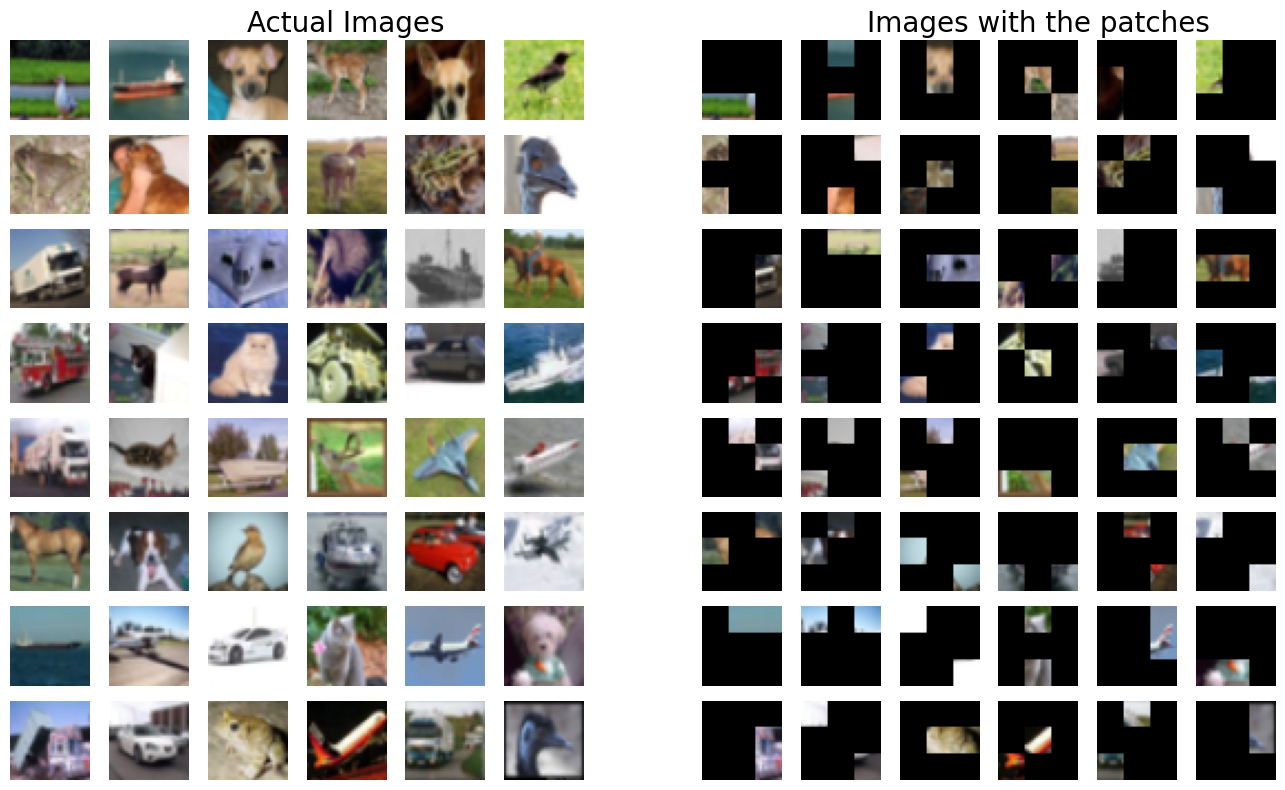

In [39]:
orig_img, patched_img, patch_1, patch_2, patch_1_idx, relative_position = next(iter(trainloader))
images_visualization(orig_img, patched_img, "Actual Images", "Images with the patches")

## Patch Prediction Model

In [40]:
# import torch.nn as nn
# import torch.optim as optim
# import pytorch_lightning as pl
# from pytorch_lightning.metrics.classification import Accuracy

class PatchPrediction(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-02, weight_decay=1e-04):
        super().__init__()

        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay
        
        # Model components
        self.featureExtractor = self._build_feature_extractor()
        self.output = self._build_classifier()

        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        
    @property
    def criterion(self):
        return nn.CrossEntropyLoss()

    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """Helper function to create a convolutional block."""
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )
        block.apply(self._init_weights)
        return block

    def _build_feature_extractor(self):
        """Construct the feature extractor part of the model."""
        layers = [
            self.conv_block(3, 16),
            self.conv_block(16, 16),
            nn.MaxPool2d(2),
            self.conv_block(16, 64),
            self.conv_block(64, 64),
            nn.MaxPool2d(2),
            self.conv_block(64, 128), #D P = 0.8
            self.conv_block(128, 128), #128*9 1024
            nn.MaxPool2d(2),
            nn.Flatten()
        ]
        return nn.Sequential(*layers)

    def _build_classifier(self):
        """Construct the classifier part of the model."""
        layers = [
            nn.Dropout(p=0.5),
            nn.Linear(128*2, 2048),
            nn.BatchNorm1d(num_features=2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, self.num_classes)
        ]
        classifier = nn.Sequential(*layers)
        classifier.apply(self._init_weights)
        return classifier

    def _init_weights(self, layer):
        """Initialize weights for convolutional and linear layers."""
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(layer.weight)
            if hasattr(layer, 'bias') and layer.bias is not None:
                layer.bias.data.fill_(0.0)

    def forward(self, patch_1, patch_2):
        patch_1_embedding = self.featureExtractor(patch_1)
        patch_2_embedding = self.featureExtractor(patch_2)
        features = torch.cat((patch_1_embedding, patch_2_embedding), dim=-1)
        return self.output(features)

    
    def training_step(self, batch, batch_idx):
        _, _, patch_1, patch_2, _, relative_position = batch
        preds = self(patch_1, patch_2)
        loss = self.criterion(preds, relative_position)
        train_acc = self.accuracy(preds, relative_position)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, patch_1, patch_2, _, relative_position = batch
        preds = self(patch_1, patch_2)
        val_loss = self.criterion(preds, relative_position)
        val_acc = self.accuracy(preds, relative_position)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        _, _, patch_1, patch_2, _, relative_position = batch
        preds = self(patch_1, patch_2)
        test_loss = self.criterion(preds, relative_position)
        test_acc = self.accuracy(preds, relative_position)
        self.log_dict({"Test_loss": test_loss, 'test_acc': test_acc}, on_step = False, on_epoch = True)
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr, weight_decay=self.weight_decay)
        return optimizer

### Model Initialisation

In [41]:
# Setting precision for float32 matrix multiplication
torch.set_float32_matmul_precision('medium')

# Initializing the PatchPrediction model
patch_prediction = PatchPrediction(num_classes, learning_rate, weight_decay)

# Configuring the Trainer
trainer_config = {
    "max_epochs": epochs,
    "devices": [0],
    "log_every_n_steps": 10
}
trainer = pl.Trainer(**trainer_config)

# Fitting the model
trainer.fit(patch_prediction, trainloader, validloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | featureExtractor | Sequential         | 271 K 
1 | output           | Sequential         | 546 K 
2 | accuracy         | MulticlassAccuracy | 0     
--------------------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.272     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 313/313 [00:05<00:00, 59.81it/s, v_num=80, Valid_loss=0.148, valid_acc=0.949, Train_loss=0.147, train_acc=0.950]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 313/313 [00:05<00:00, 59.43it/s, v_num=80, Valid_loss=0.148, valid_acc=0.949, Train_loss=0.147, train_acc=0.950]


### Model Metrics

In [42]:
metric = pd.read_csv('lightning_logs/version_80/metrics.csv')
metric.head()

,Valid_loss,valid_acc,epoch,step,Train_loss,train_acc
0,1.766310,0.2792,0,312,NaN,NaN
1,NaN,NaN,0,312,2.159338,0.1881
2,1.124704,0.4852,1,625,NaN,NaN
3,NaN,NaN,1,625,1.403505,0.3966
4,0.529454,0.8058,2,938,NaN,NaN


In [43]:
def extract_values(column_name):
    return metric[~metric[column_name].isna()][column_name].values

valid_losses = extract_values('Valid_loss')
train_losses = extract_values('Train_loss')
valid_accuracy = extract_values('valid_acc')
train_accuracy = extract_values('train_acc')


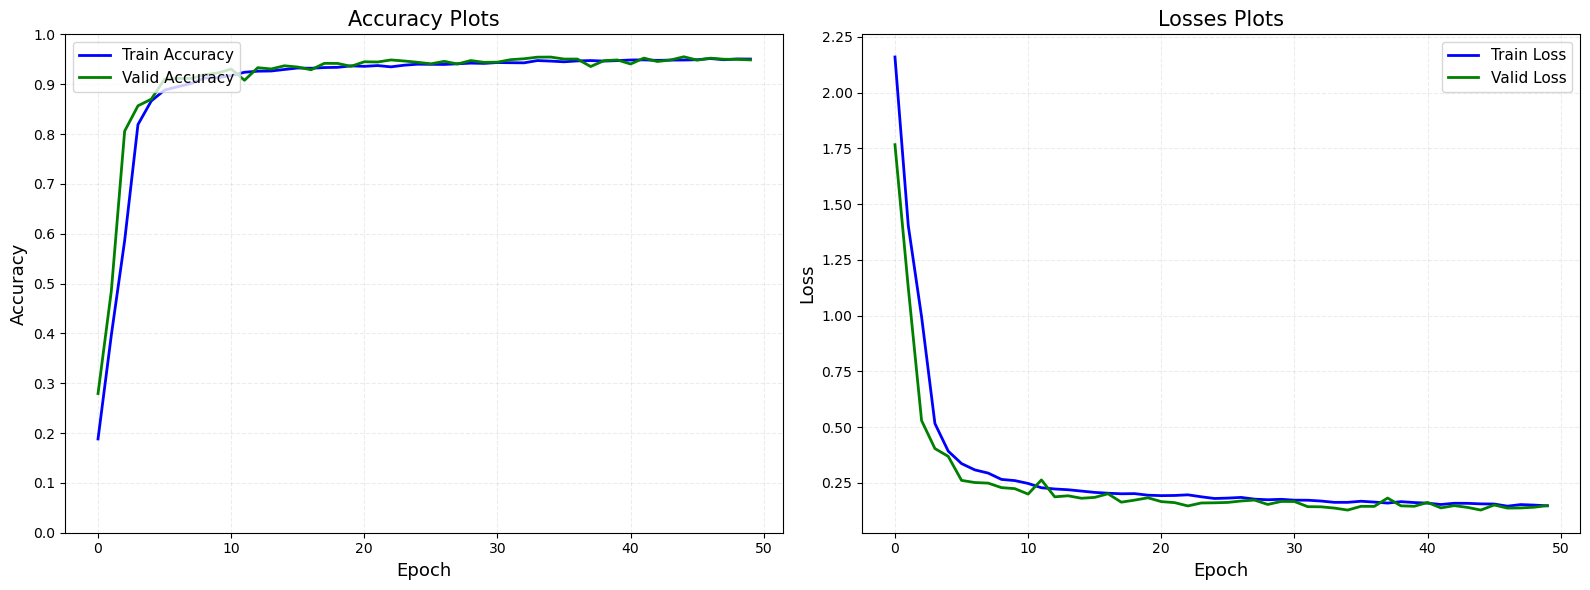

In [44]:
plt.style.use('default')  # Switch to a default style for a formal appearance

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the accuracies
axes[0].plot(train_accuracy, label="Train Accuracy", linewidth=2, color='blue')
axes[0].plot(valid_accuracy, label="Valid Accuracy", linewidth=2, color='green')
axes[0].set_title('Accuracy Plots', fontsize=15)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Accuracy', fontsize=13)
axes[0].set_yticks(np.arange(0.0, 1.1, 0.1))
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, linestyle='--', which='major', color='gray', alpha=.15)

# Plotting the losses
axes[1].plot(train_losses, label="Train Loss", linewidth=2, color='blue')
axes[1].plot(valid_losses, label="Valid Loss", linewidth=2, color='green')
axes[1].set_title('Losses Plots', fontsize=15)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Loss', fontsize=13)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, linestyle='--', which='major', color='gray', alpha=.15)

# Display the plot
plt.tight_layout()
plt.show()


### Test Results

In [45]:
trainer.test(patch_prediction, dataloaders=testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 100.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test_loss         │     0.147536501288414     │
│         test_acc          │    0.9484000205993652     │
└───────────────────────────┴───────────────────────────┘

[{'Test_loss': 0.147536501288414, 'test_acc': 0.9484000205993652}]

## Visualize Results

In [46]:
def repatch_images(patch_1, patch_2, patch_1_idx, predicted_patch_idx):
    def place_patch_on_image(image, patch, idx):
        """Helper function to place the patch on the image at the given index."""
        patch_size = 12
        row, col = idx // 3, idx % 3
        start_row, end_row = row * patch_size, (row + 1) * patch_size
        start_col, end_col = col * patch_size, (col + 1) * patch_size
        image[:, start_row:end_row, start_col:end_col] = patch
        
    # Get the index for the second patch using the permutation
    patch_2_idx = permutations[int(patch_1_idx)][int(predicted_patch_idx)]
    
    # Create an empty canvas for the final image
    patched_img = torch.zeros((3, 36, 36))
    
    # Place the patches on the canvas
    place_patch_on_image(patched_img, patch_1.detach().cpu(), patch_1_idx)
    place_patch_on_image(patched_img, patch_2.detach().cpu(), patch_2_idx)
    
    return patched_img


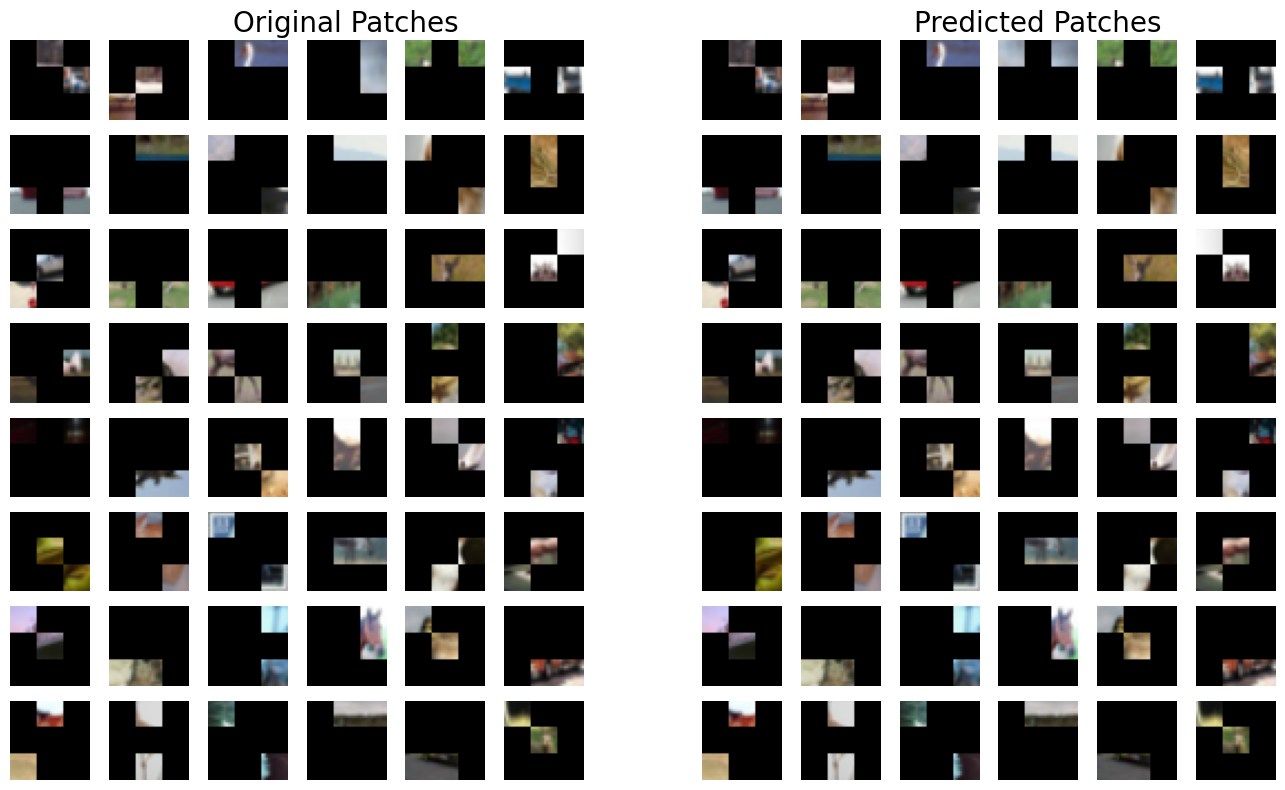

In [47]:
def get_predicted_patches_for_batch(patch_1_batch, patch_2_batch, patch_1_idx_batch, predictions_batch):
    """Generate predicted patch positions for an entire batch."""
    return torch.stack([
        repatch_images(patch_1, patch_2, patch_1_idx, pred)
        for patch_1, patch_2, patch_1_idx, pred in zip(patch_1_batch, patch_2_batch, patch_1_idx_batch, predictions_batch)
    ])

# Fetch the next batch from the validloader
orig_img, patched_img, patch_1, patch_2, patch_1_idx, relative_position = next(iter(validloader))

# Get the predicted class labels for each image in the batch
predictions = torch.argmax(patch_prediction(patch_1, patch_2), dim=-1)

# Get the predicted patches for the entire batch
predicted_patches = get_predicted_patches_for_batch(patch_1, patch_2, patch_1_idx, predictions)

# Visualize the images
images_visualization(patched_img, predicted_patches, 'Original Patches', 'Predicted Patches')


# For Classification Task

## Dataloader

In [48]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=train_transforms)
cifar10_test = datasets.CIFAR10('./data', train=False, transform=test_transforms)

In [49]:
train_loader = DataLoader(cifar10_train, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, num_workers=2)

In [50]:
cifar10_train[0][0].shape,cifar10_train[0][1]

(torch.Size([3, 36, 36]), 6)

## Classification Model

In [82]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, num_classes, num_freeze=-1):
        super().__init__()

        self.num_classes = num_classes
        # Model components
        self.featureExtractor = self._build_feature_extractor()
        self.output = self._build_classifier()
        
        self.freeze_layers(num_freeze)
        self.accuracy = Accuracy(task='multiclass', num_classes=10)

    @property
    def criterion(self):
        return nn.CrossEntropyLoss()

    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )
        block.apply(self._init_weights)
        return block

    def _build_feature_extractor(self):
        layers = [
            self.conv_block(3, 16),  # L0
            self.conv_block(16, 16), #L1
            nn.MaxPool2d(2), #L2
            self.conv_block(16, 64), #L3
            self.conv_block(64, 64), #L4
            nn.MaxPool2d(2), #L5
            self.conv_block(64, 128), #D P = 0.8 #L6
            self.conv_block(128, 128), #128*9 1024
            nn.MaxPool2d(2),
            nn.Flatten()            
        ]
        return nn.Sequential(*layers)

    def _build_classifier(self):
        layers = [
            nn.Dropout(p=0.5),
            nn.Linear(256, 2048),
            nn.BatchNorm1d(num_features=2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, self.num_classes)
        ]
        classifier = nn.Sequential(*layers)
        classifier.apply(self._init_weights)
        return classifier

    def _init_weights(self, layer):
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(layer.weight)
            if hasattr(layer, 'bias') and layer.bias is not None:
                layer.bias.data.fill_(0.0)

    def freeze_layers(self, num_freeze):
        for idx, child in enumerate(self.featureExtractor.children()):
            if num_freeze == -1:
                for param in child.parameters():
                    param.requires_grad = False
                continue

            else:
                if idx >= num_freeze:
                    break
                for param in child.parameters():
                    param.requires_grad = False

    def forward(self, x):
        features = self.featureExtractor(x)
        return self.output(features)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.criterion(preds, labels)
        train_acc = self.accuracy(preds, labels)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        val_loss = self.criterion(preds, labels)
        val_acc = self.accuracy(preds, labels)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        test_loss = self.criterion(preds, labels)
        test_acc = self.accuracy(preds, labels)
        self.log_dict({"Test_loss": test_loss, 'test_acc': test_acc}, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-03)
        return optimizer


### Instantiating Model

In [83]:
classification_model = ClassificationModel(num_classes=8, num_freeze=7)
checkpoint = torch.load('./lightning_logs/version_80/checkpoints/epoch=49-step=15650.ckpt')
classification_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [89]:
# Removing the output with classifier
classification_model.output = nn.Sequential(nn.Dropout(p = 0.75),
                                    nn.Linear(2048, 4096),
                                    nn.BatchNorm1d(num_features=4096),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(4096, 10) # Since CIFAR 10 have 10 classes
                                   )

In [90]:
torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(max_epochs = epochs, devices=[0], log_every_n_steps=10)
trainer.fit(classification_model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | featureExtractor | Sequential         | 271 K 
1 | output           | Sequential         | 8.4 M 
2 | accuracy         | MulticlassAccuracy | 0     
--------------------------------------------------------
8.6 M     Trainable params
123 K     Non-trainable params
8.7 M     Total params
34.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cminds/miniconda3/envs/gnr/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 391/391 [00:04<00:00, 89.86it/s, v_num=88, Valid_loss=1.260, valid_acc=0.576, Train_loss=1.040, train_acc=0.634] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 391/391 [00:04<00:00, 84.34it/s, v_num=88, Valid_loss=1.260, valid_acc=0.576, Train_loss=1.040, train_acc=0.634]


### Metrics

In [91]:
metric = pd.read_csv('lightning_logs/version_88/metrics.csv')
metric.head()

,Valid_loss,valid_acc,epoch,step,Train_loss,train_acc
0,1.422285,0.5027,0,390,NaN,NaN
1,NaN,NaN,0,390,1.753761,0.3937
2,1.392231,0.5016,1,781,NaN,NaN
3,NaN,NaN,1,781,1.605840,0.4371
4,1.374054,0.5147,2,1172,NaN,NaN


In [92]:
def extract_values(column_name):
    return metric[~metric[column_name].isna()][column_name].values

valid_losses = extract_values('Valid_loss')
train_losses = extract_values('Train_loss')
valid_accuracy = extract_values('valid_acc')
train_accuracy = extract_values('train_acc')


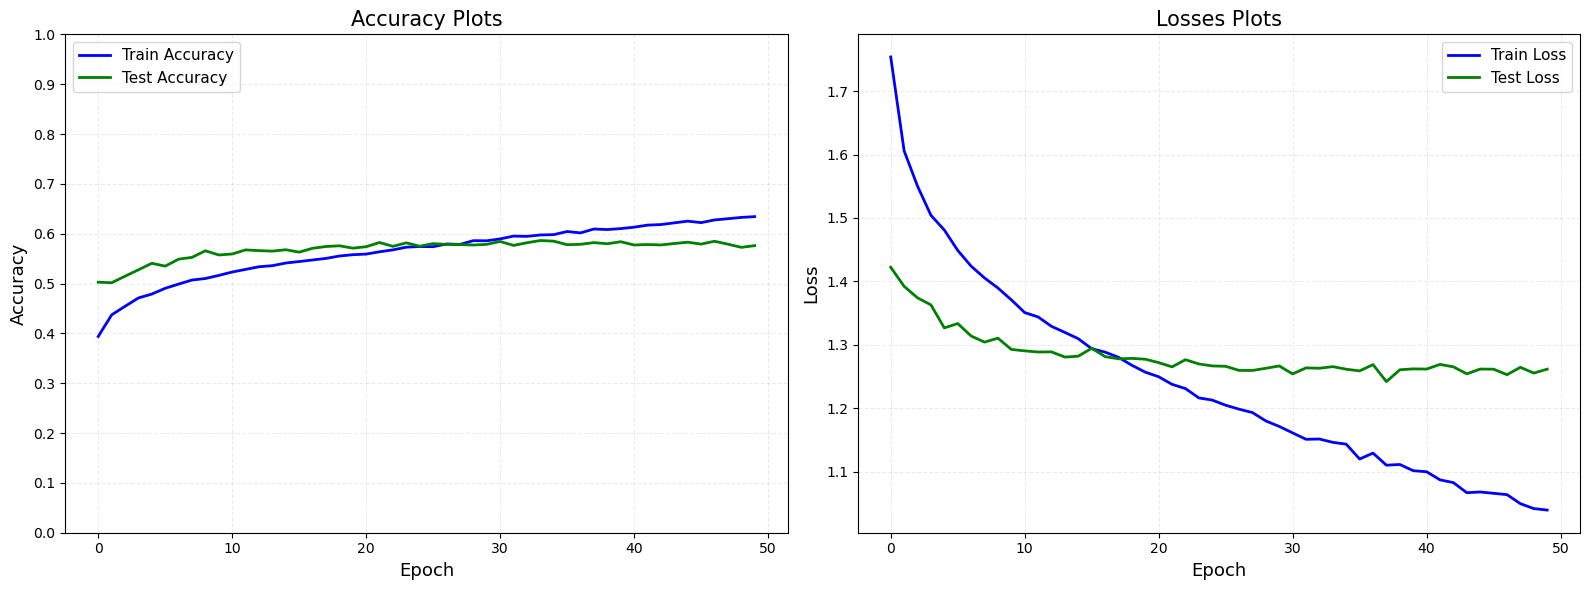

In [93]:
plt.style.use('default')  # Switch to a default style for a formal appearance

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the accuracies
axes[0].plot(train_accuracy, label="Train Accuracy", linewidth=2, color='blue')
axes[0].plot(valid_accuracy, label="Test Accuracy", linewidth=2, color='green')
axes[0].set_title('Accuracy Plots', fontsize=15)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Accuracy', fontsize=13)
axes[0].set_yticks(np.arange(0.0, 1.1, 0.1))
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, linestyle='--', which='major', color='gray', alpha=.15)

# Plotting the losses
axes[1].plot(train_losses, label="Train Loss", linewidth=2, color='blue')
axes[1].plot(valid_losses, label="Test Loss", linewidth=2, color='green')
axes[1].set_title('Losses Plots', fontsize=15)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Loss', fontsize=13)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, linestyle='--', which='major', color='gray', alpha=.15)

# Display the plot
plt.tight_layout()
plt.show()


## Gradcam

In [23]:
import cv2
import numpy as np
import torch

def gradcam_visualization(img, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img = img.to(device)[None]
    
    # Prepare the model and extract features
    model.to(device)
    model.unfreeze()
    model.eval()
    activation_network = model.featureExtractor[:-3]
    category = model(img)
    category = torch.max(category, dim=-1)[0]
    feature_maps = activation_network(img)
    model.zero_grad()
    
    # Backpropagate the signals
    category.backward(retain_graph=True)
    gradients_mean = get_gradients_mean(model)
    feature_maps = weight_feature_maps_by_gradients(feature_maps, gradients_mean)
    
    # Generate heatmap
    heatmap = generate_heatmap(feature_maps)
    
    # Post-process and overlay heatmap on image
    final_img = overlay_heatmap_on_image(heatmap, img)
    
    return final_img

def get_gradients_mean(model):
    return model.featureExtractor[-3][0].weight.grad.data.mean((0,2,3))

def weight_feature_maps_by_gradients(feature_maps, gradients_mean):
    for i in range(len(gradients_mean)):
        feature_maps[:, i, :, :] *= gradients_mean[i]
    return feature_maps

def generate_heatmap(feature_maps):
    heatmap = torch.mean(feature_maps, dim=1)[0].cpu().detach()
    heatmap = normalize_tensor(heatmap)
    heatmap = heatmap.numpy()
    heatmap = (heatmap * 255).astype(np.uint8)
    return heatmap

def normalize_tensor(tensor):
    min_value, max_value = tensor.min(), tensor.max()
    return (tensor - min_value) / (max_value - min_value)

def overlay_heatmap_on_image(heatmap, img):
    ALPHA = 0.3
    BETA = 0.7
    
    img = (img[0].cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(255 - heatmap_resized, cv2.COLORMAP_JET)
    
    combined = (ALPHA * heatmap_colored + BETA * img).astype(np.uint8)
    return torch.tensor(combined.transpose(2, 0, 1)) / 255.



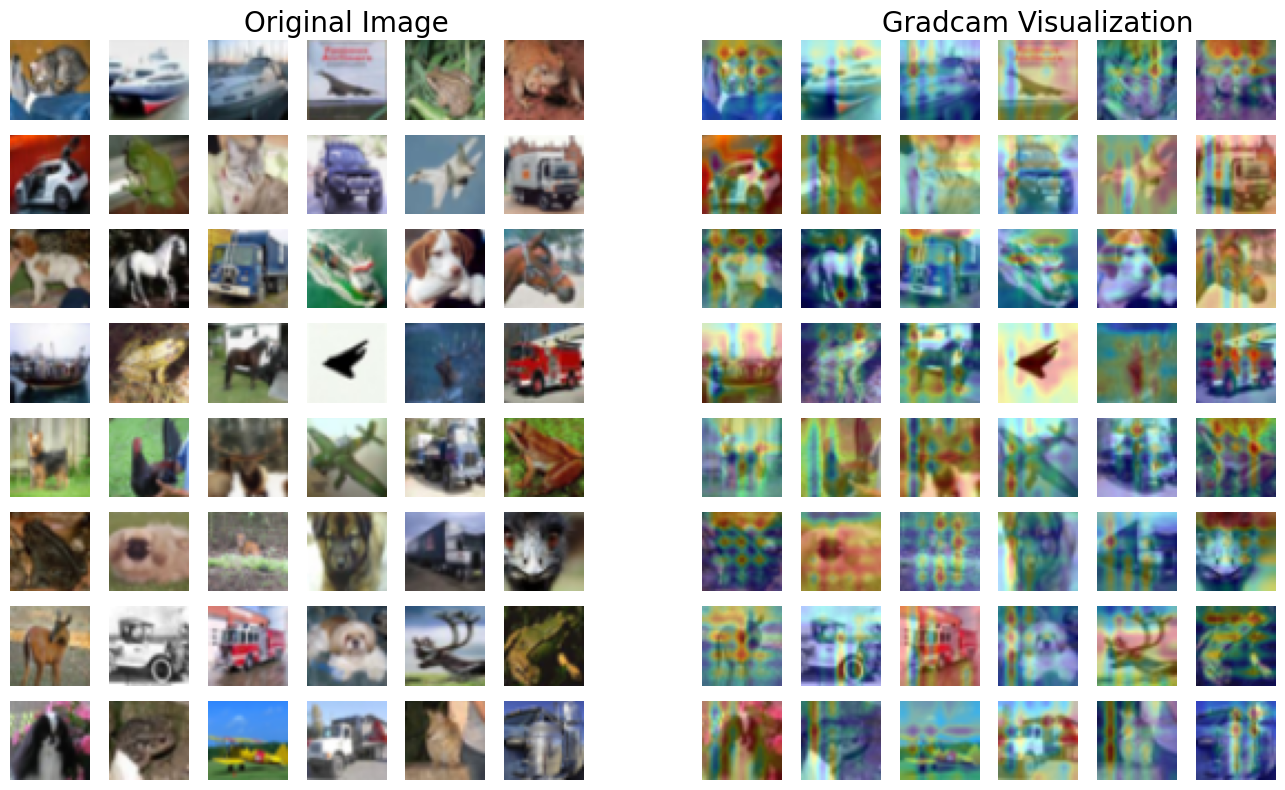

In [33]:
imgs, lbls= next(iter(test_loader))
grad_cam_images = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    grad_cam_images[i] = gradcam_visualization(imgs[i], classification_model)
images_visualization(imgs, grad_cam_images, 'Original Image', 'Gradcam Visualization')

In [25]:
,

''